In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [3]:
data.head()

,Time,Weighted_Price,Total_Size,Order_Number
0,10.881,267.0,1.0,1.0
1,11.067,269.0,1.0,1.0
2,11.222,267.0,2.0,1.0
3,12.338,270.0,2.0,1.0
4,13.733,267.0,3.0,1.0


In [4]:
data_copy = data[['Time','Weighted_Price']].copy()

In [5]:
data_copy

,Time,Weighted_Price
0,10.881,267.000000
1,11.067,269.000000
2,11.222,267.000000
3,12.338,270.000000
4,13.733,267.000000
...,...,...
18570,30594.830,285.333333
18571,30596.225,286.000000
18572,30598.085,287.500000
18573,30599.108,292.000000


In [6]:
max_time = data_copy['Time'].max()
min_time = data_copy['Time'].min()

# Calculate the correct range of bins, ensuring that we include the maximum time
# Add 10 to max_time to create a bin that includes the last data point if it falls exactly on a 10-second mark
time_bins = range(int(min_time) - (int(min_time) % 10), int(max_time) + 10, 10)

# Now we'll bin the data again using the corrected time bins
data_copy['time_bin'] = pd.cut(data_copy['Time'], bins=time_bins, right=False)

# Calculate the counts for each bin
corrected_bin_counts = data_copy['time_bin'].value_counts().sort_index()

# Converting the bin counts to a more readable string format
readable_corrected_bin_counts = corrected_bin_counts.rename(lambda x: f"{int(x.left)}-{int(x.right)}")
readable_corrected_bin_counts

time_bin
10-20          7
20-30          8
30-40          4
40-50          7
50-60          6
              ..
30550-30560    6
30560-30570    7
30570-30580    3
30580-30590    9
30590-30600    7
Name: count, Length: 3059, dtype: int64

In [7]:
def resample_and_adjust_using_original_times(df, target_count):
    # Creating a new column 'Time_bin' to convert 'Time' values into 10-second bins
    df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
    
    all_time_bins = range(df['Time_bin'].min(), df['Time_bin'].max() + 10, 10)
    grouped = df.groupby('Time_bin')

    new_records = []
    last_known_price = None 
    
    # Iterating through all possible time bins
    for time_bin in all_time_bins:
        # If the current time bin exists within the grouped data
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            # If the prices array is not empty, update the last known price
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None 
            
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))

    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df

processed_df = resample_and_adjust_using_original_times(data_copy, 6)

In [8]:
processed_df

,Time,Weighted_Price
0,10.8810,267.000000
1,11.1445,268.000000
2,12.3380,270.000000
3,13.7330,267.000000
4,18.3210,265.000000
...,...,...
18349,30591.2960,288.250000
18350,30594.8300,285.333333
18351,30596.2250,286.000000
18352,30598.0850,287.500000


In [9]:
price = processed_df['Weighted_Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price)

In [10]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [11]:
time_step = 100

In [12]:
X, y = create_dataset(scaled_data, time_step)

In [13]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [14]:
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [18]:
len(X_test)

3651

In [19]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 0.0314 - val_loss: 0.0049
Epoch 2/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 12/100
229/22

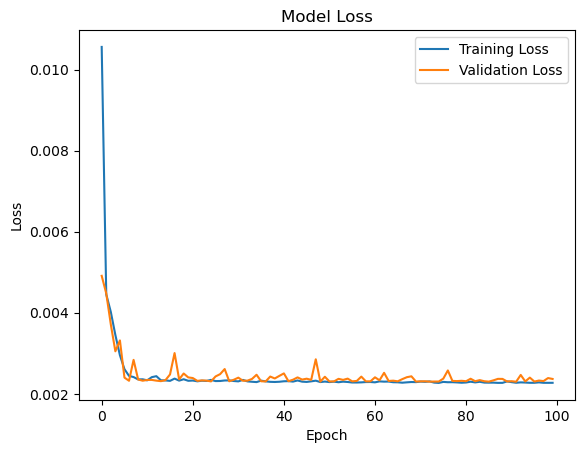

In [22]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()

In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scaling

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [25]:
len(predictions)

3651

In [28]:
rmse = np.sqrt(mean_squared_error(processed_df[split_index+time_step:], predictions))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 2.9197343753405574


In [27]:
processed_df['Time'] = pd.to_datetime(processed_df['Time'], unit='s')
processed_df.set_index('Time',inplace=True)

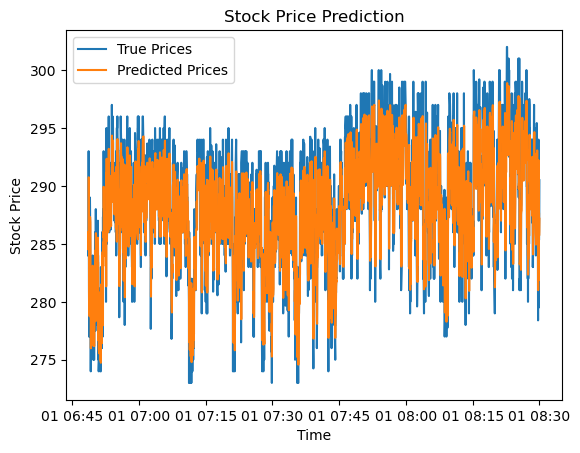

In [31]:
plt.plot(processed_df[split_index+time_step:].index, processed_df[split_index+time_step:], label='True Prices')
plt.plot(processed_df[split_index+time_step:].index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()